In [2]:
import preprocess
import plot
import analysis
from model import WGAN_GP
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import tensorflow as tf

# Load dataset and pretrained model

In [3]:
refpath = '83.93_reference.tab'
genepath = 'DESeq2_htseq/AD7M_over_WT7M_q005_baseMean100_PMean.csv'
datapath = 'DESeq2_htseq/GSE104775_RLD_w_HG.csv'

In [4]:
#Prepare dataset
ex_gnames, ex_glists = preprocess.gene_filtering(refpath, genepath)
ex_value, ex_gene, ex_label = preprocess.extract_filtered_gene(datapath, ex_gnames)
metadatas = preprocess.get_metadata(ex_label)
augmented_data = preprocess.data_augmentation(ex_value, ex_gene, metadatas, False)
gaus_augmented_data = preprocess.gaussian_augmentation(ex_value, ex_gene, metadatas, 141, False)

# filtered genes: (1208,) , data.shape : (72, 1208)
augmented_data.shape : (846, 1208)
gaussian augmented_data.shape : (846, 1208)


In [5]:
#data normalization
egene, rlds, aug_ages, aug_types, sp_size = augmented_data
print (egene.shape, rlds.shape, aug_ages.shape, aug_types.shape)

rcond_list, augcond_list = preprocess.indexing(aug_types, np.int(rlds.shape[0]/sp_size), sp_size)
re_rld, rld_mean, max_rld_std, std_re_rld = preprocess.rescaling(rlds, augcond_list)
print (re_rld.shape, rld_mean.shape, max_rld_std.shape, std_re_rld.shape)

(1208,) (846, 1208) (846,) (846,)
(846, 1208) (1208,) (1208,) ()


In [6]:
#Load split data
split = np.load('data_split.npz')
xtr, xte = re_rld[split['tridx']], re_rld[split['teidx']]
n, p = xtr.shape
n_tr, n_te = len(xtr), len(xte)
print ('xtr.shape:', xtr.shape, 'xte.shape:', xte.shape)

xtr.shape: (762, 1208) xte.shape: (84, 1208)


In [7]:
wgangp = WGAN_GP(xtr, n_te)

t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
g_vars = [var for var in t_vars if var.name.startswith('generator')]




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Training results

(200000,) (200000,) (400, 84, 1208)


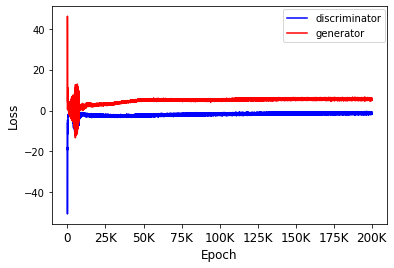

In [8]:
savepath = 'weights/'

#load data
dat_ = np.load(savepath+'training_results.npz')
dloss, gloss, genx = dat_['dloss'], dat_['gloss'], dat_['genx']
print (dloss.shape, gloss.shape, genx.shape)

plot.loss_graph(dloss, gloss)

In [11]:
gen_gen_corr = analysis.calculate_corr(genx, genx)
gen_real_corr = analysis.calculate_corr(genx, xte)
real_real_corr = analysis.calculate_corr(re_rld, re_rld)
print (gen_real_corr.shape, gen_gen_corr.shape, real_real_corr.shape)

(400, 84, 84) (400, 84, 84) (846, 846)


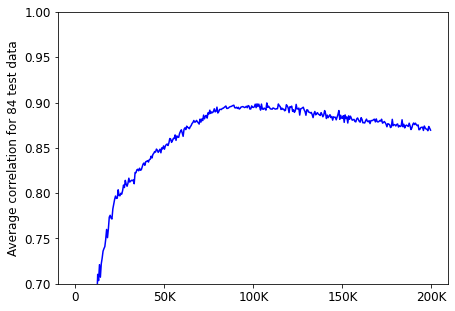

In [12]:
max_gen_real_corr = np.average(np.max(gen_real_corr, axis=1), axis=1)
plot.avg_corr_graph(max_gen_real_corr)

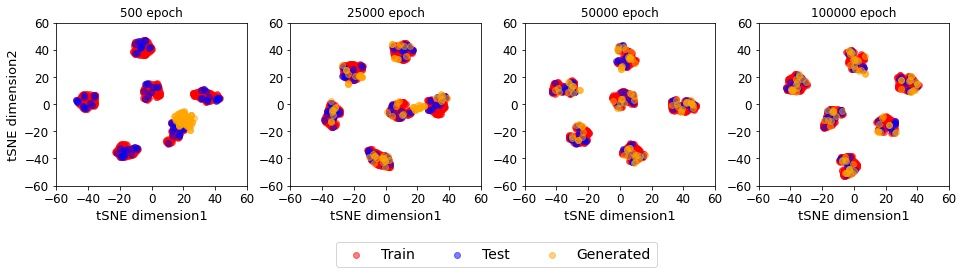

In [13]:
plot.tsne(xtr, xte, genx, ep_ary=[0,49,99,199])

In [14]:
loadpath = 'weights/ep100000'
n_noise = 10000

genaugx = analysis.generate_augx(re_rld, loadpath, wgangp, n_noise)
real_aug_corr = analysis.calculate_corr(re_rld, genaugx)
print (genaugx.shape, real_aug_corr.shape)

(846, 1208) (846, 846)


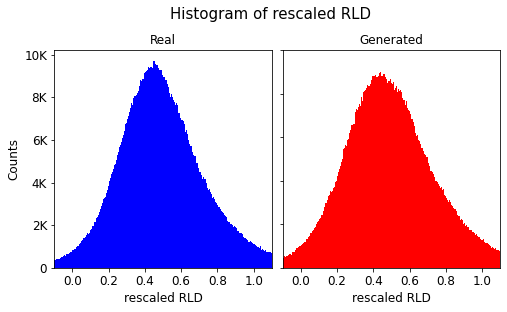

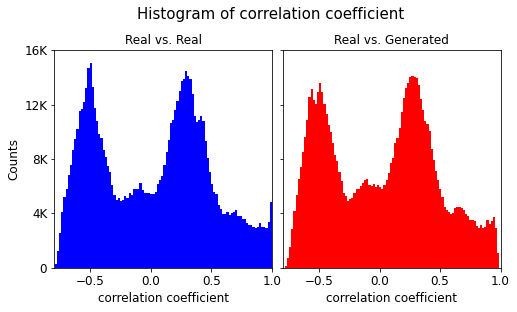

In [15]:
sbin = int((np.max(re_rld.flatten())-np.min(re_rld.flatten()))/.005)

plot.histograms([re_rld, genaugx], sbin, 'Histogram of rescaled RLD', ['Real', 'Generated'])
plot.histograms([real_real_corr, real_aug_corr], 100, 'Histogram of correlation coefficient', ['Real vs. Real', 'Real vs. Generated'])

In [18]:
#re-ordering
WTAD_augcond_list = [[augcond_list[3],augcond_list[0]],[augcond_list[4],augcond_list[1]],[augcond_list[5],augcond_list[2]]]
ep_ary = np.arange(0,50500,500)+75000
path = 'weights/'

WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gencorr, gen_fw = analysis.latent_interpolation(path, wgangp, re_rld, g_vars, WTAD_augcond_list, ep_ary, n_noise=10000)
print (WTAD_z.shape, WTAD_avgz.shape, WTAD_genx.shape, WTAD_gencorr.shape, gen_fw.shape)

# Analyse results

In [19]:
#load base weights(100k)
loadpath = 'weights/ep100000'
wgangp.load_weight(loadpath)

INFO:tensorflow:Restoring parameters from weights/ep100000.ckpt


In [20]:
#load results of latent interpolation
"""
z:(epochs,types(WT/AD),age(2/4/7M),#augsamples,zdim)
avgz:(epochs,ages(2/4/7M),zdim)
genx:(epochs,ages(2/4/7M),#augsamples,interpolate_stpes,p)
gencorr:(epochs,types(WT/AD),age(2/4/7M),#augsamples)
fw:(epochs,fw.shape)
"""
tdat = np.load('weights/generated_from_75k_to_125k.npz')
WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gencorr, gen_fw = tdat['WTAD_z'], tdat['WTAD_avgz'], tdat['WTAD_genx'], tdat['WTAD_gencorr'], tdat['gen_fw']
print (WTAD_z.shape, WTAD_avgz.shape, WTAD_genx.shape, WTAD_gencorr.shape, gen_fw.shape)

(101, 2, 3, 141, 100) (101, 3, 100) (101, 3, 141, 101, 1208) (101, 2, 3, 141) (101, 250, 1208)


In [21]:
#extract real
WTAD_rz, WTAD_rgencorr, WTAD_rgenx = WTAD_z[:,:,:,rcond_list[0]], WTAD_gencorr[:,:,:,rcond_list[0]], WTAD_genx[:,:,rcond_list[0]]
print (WTAD_rz.shape, WTAD_rgencorr.shape, WTAD_rgenx.shape)

(101, 2, 3, 6, 100) (101, 2, 3, 6) (101, 3, 6, 101, 1208)


In [22]:
#idx50:100k
fWTAD_rz = WTAD_rz[50].reshape((np.prod(WTAD_rz[50].shape[:3]), WTAD_rz[50].shape[-1]))
fWTAD_rz = np.concatenate((fWTAD_rz[18:], fWTAD_rz[:18]),axis=0) #reordering
print (fWTAD_rz.shape)

rgenx_100k = wgangp.generate_samples(fWTAD_rz)
rgencorr_100k = WTAD_rgencorr[50].flatten()
print (rgenx_100k.shape, rgencorr_100k.shape)

(36, 100)
(36, 1208) (36,)


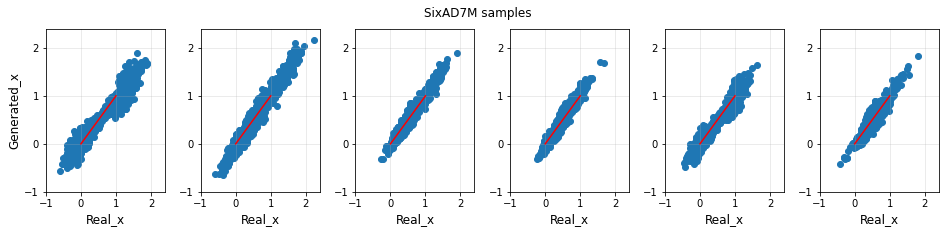

In [23]:
#(Val1) Compare realx and genx
##rcond_list:[AD2/4/7M, WT2/4/7M]
plot.compare_realx_and_genx(re_rld, rgenx_100k, rcond_list, 2)

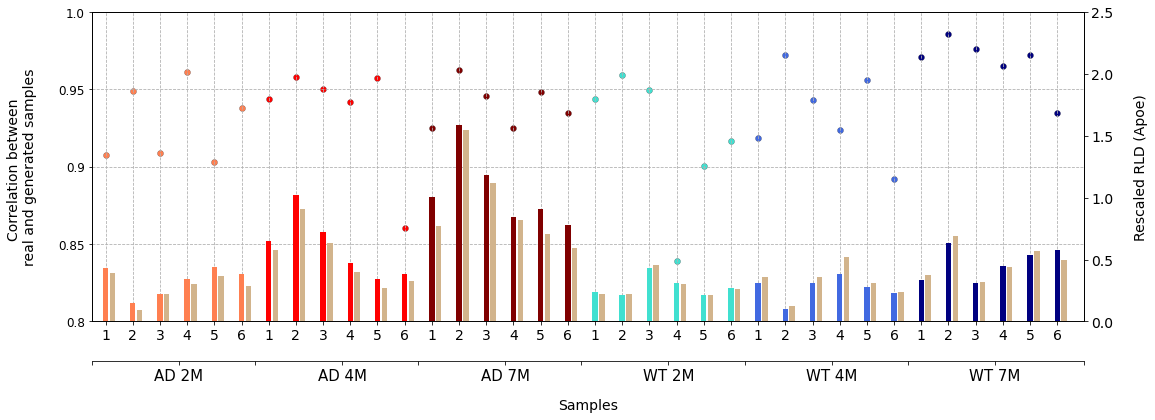

In [24]:
#(Val2) Compare within specific genes
kwd = 'Apoe'
plot.compare_real_and_gen_gene(re_rld, rgenx_100k, rgencorr_100k, rcond_list, ex_glists, kwd)

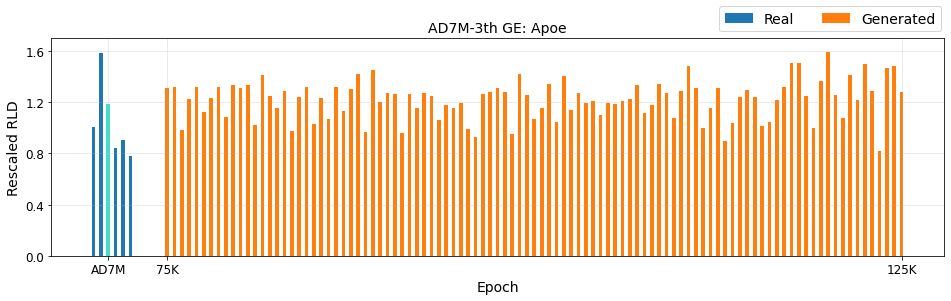

In [25]:
#(Val3) Fluctuation through epochs-AD_7M_3rd sample
kwd = 'Apoe'
condidx, spidx = 2, 3 #AD7M-3rd sample
plot.genx_through_training(kwd, re_rld, WTAD_rgenx, rcond_list, condidx, spidx, ex_glists)

In [26]:
genx_A = np.average(np.average(WTAD_genx, axis=2), axis=0)
genx_S = np.std(np.average(WTAD_genx, axis=2), axis=0)
print (genx_A.shape, genx_S.shape)

(3, 101, 1208) (3, 101, 1208)


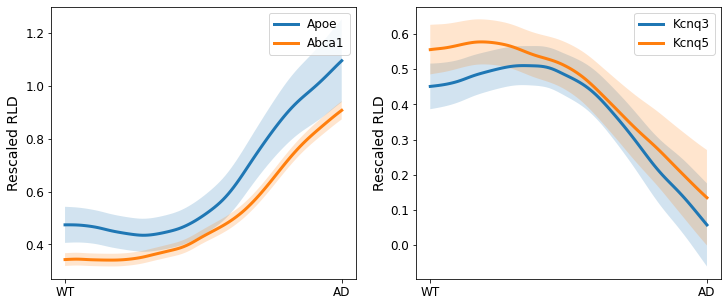

In [27]:
flist = [['Apoe', 'Abca1'], ['Kcnq3', 'Kcnq5']]
plot.transition_curves(genx_A, genx_S, ex_glists, flist)

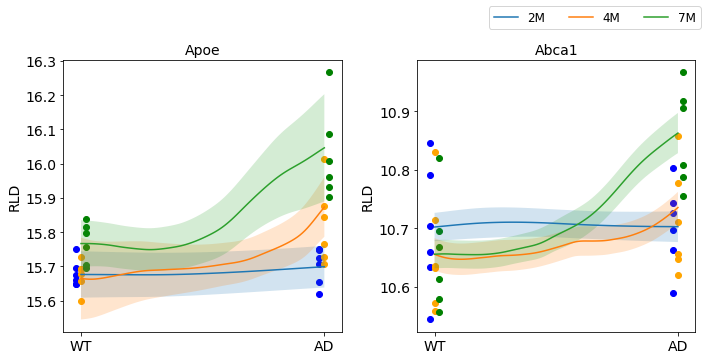

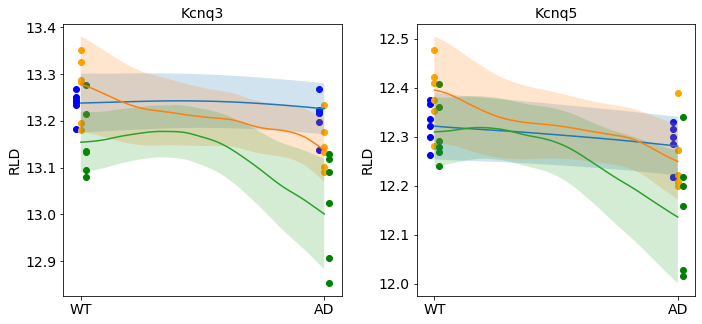

In [28]:
flist = [['Apoe', 'Abca1'], ['Kcnq3', 'Kcnq5']]
plot.transition_curves_all(rlds, genx_A, genx_S, rld_mean, std_re_rld, max_rld_std, rcond_list, ex_glists, flist)

/Users/jinhee/Documents/kbri/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


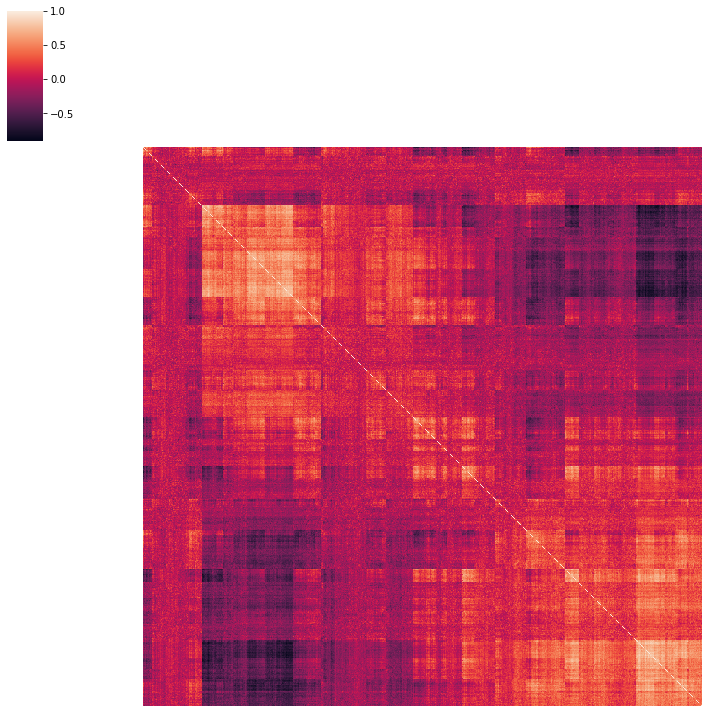

In [30]:
#AD_7M-3rd samples
genx_sub = re_rld[rcond_list[2][2]]-WTAD_rgenx[:,2,2,-1]
plot.heatmap(genx_sub)

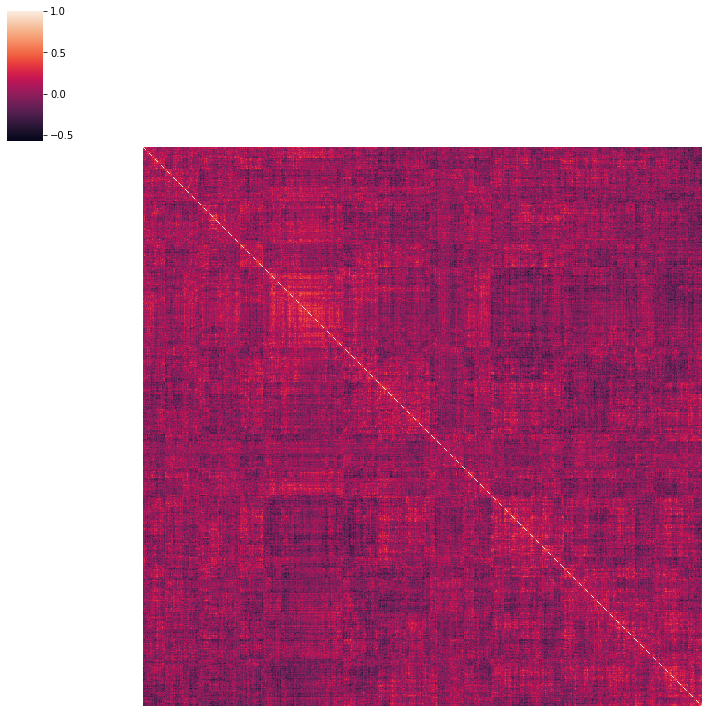

In [34]:
#weight of generator
gen_fw_corr = []
for ep in range(len(ep_ary)):
    gen_fw_corr_ = np.zeros((p,p))
    for g1 in range(p):
        for g2 in range(p):
            gen_fw_corr_[g1,g2]=scipy.stats.pearsonr(gen_fw[ep,:,g1],gen_fw[ep,:,g2])[0]
    gen_fw_corr.append(gen_fw_corr_)
gen_fw_corr = np.array(gen_fw_corr)

avg_genfw_corr = np.average(gen_fw_corr, axis=0)

avg_genfw_gheat = sns.clustermap(avg_genfw_corr, metric='euclidean', method='complete', xticklabels="", yticklabels="")
avg_genfw_gheat.ax_row_dendrogram.set_visible(False)
avg_genfw_gheat.ax_col_dendrogram.set_visible(False)

Save, weights/weight_network.csv


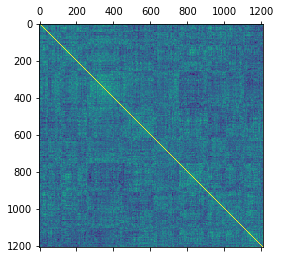

In [35]:
#extract specific regions from heatmap
analysis.extract_specific_cond_glists(avg_genfw_corr, avg_genfw_gheat, 0.4, ex_glists)

In [36]:
phtml = 'rld1_gse104775_genx_247m_75k_125k/Webgestalt/' 
html_uplist = ['WikiPathway/7M_WP_up/Report_wg_result1564017121.html', 'KEGG/7M_KEGG_up/Report_wg_result1564031797.html', 'GO_BP/7M_GO_BP_up/Report_wg_result1564032007.html']
html_dnlist = ['WikiPathway/7M_WP_down/Report_wg_result1564017126.html', 'KEGG/7M_KEGG_down/Report_wg_result1564031792.html', 'GO_BP/7M_GO_BP_down/Report_wg_result1564032002.html']

upplist = np.array(['WP103', 'mmu04666', 'GO:0007229'])
dnplist = np.array(['WP434', 'mmu04721', 'GO:0001505'])

In [37]:
up_texts, up_res = analysis.get_data_from_html(phtml, html_uplist)
dn_texts, dn_res = analysis.get_data_from_html(phtml, html_dnlist)

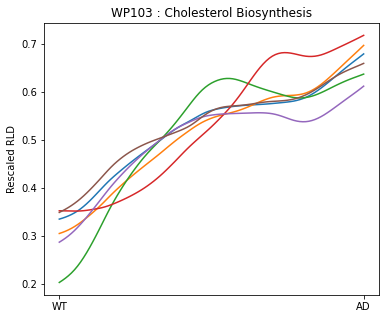

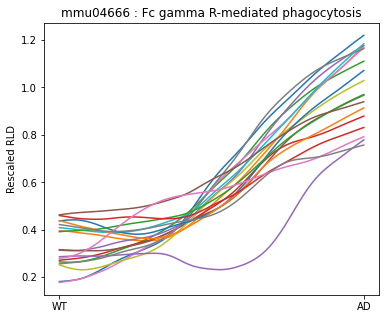

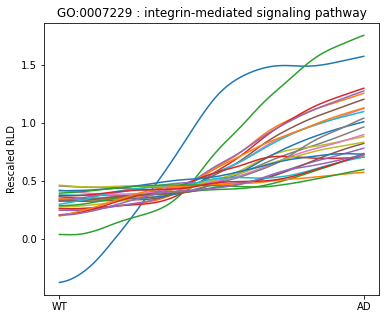

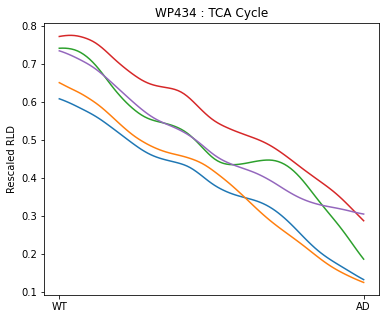

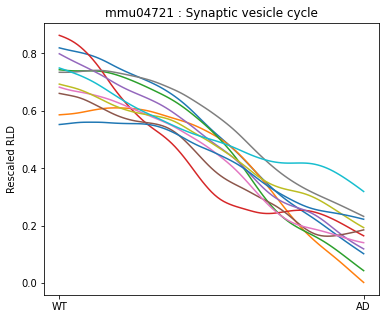

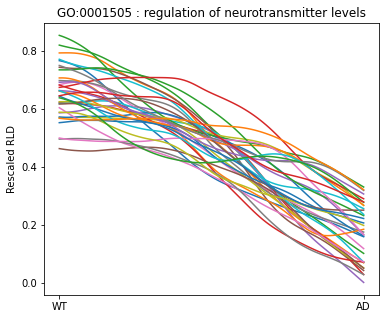

In [38]:
plot.transition_curves_with_plist(upplist, up_texts, up_res, genx_A, ex_glists)
plot.transition_curves_with_plist(dnplist, dn_texts, dn_res, genx_A, ex_glists)

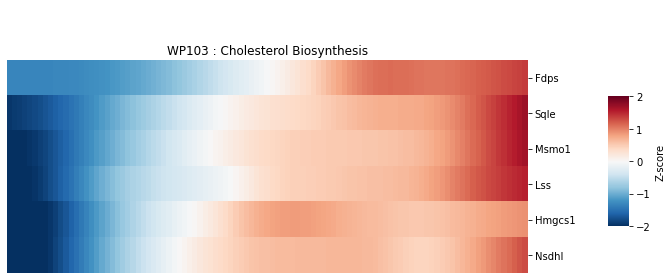

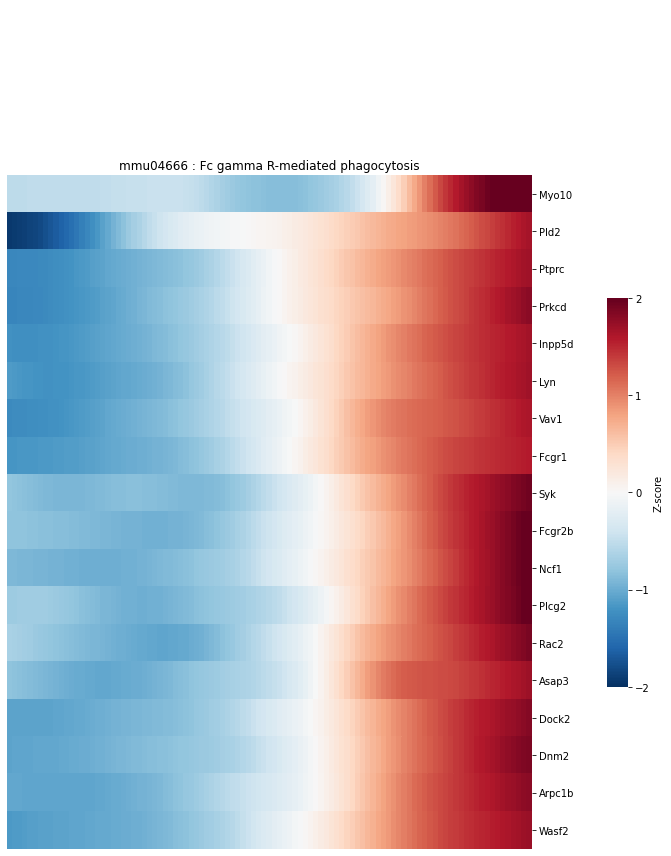

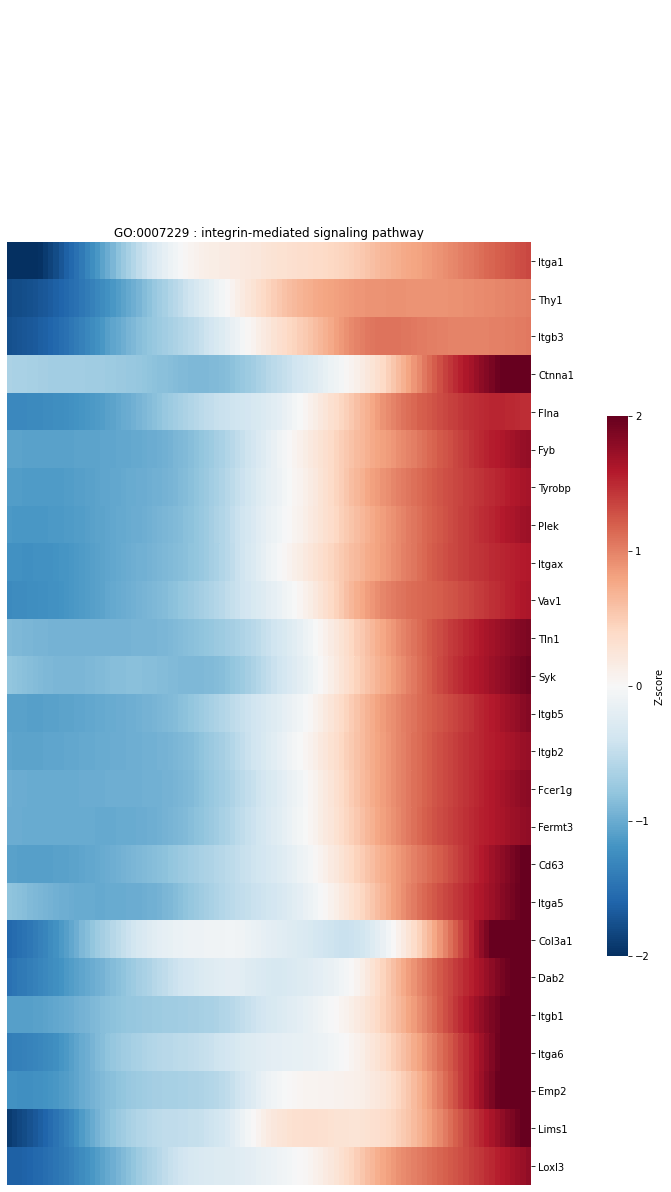

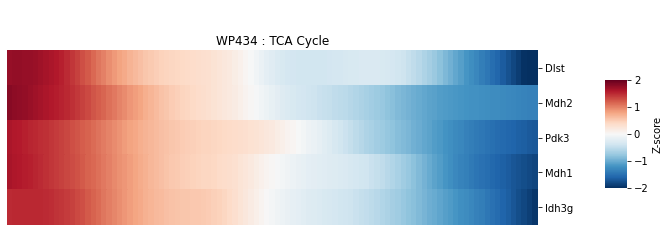

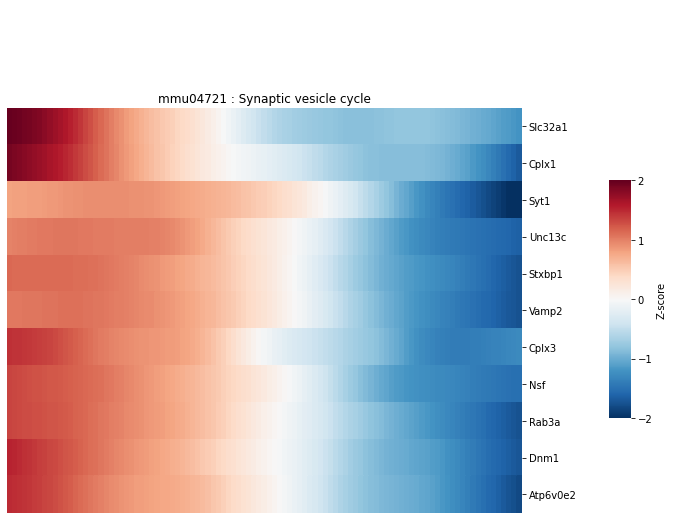

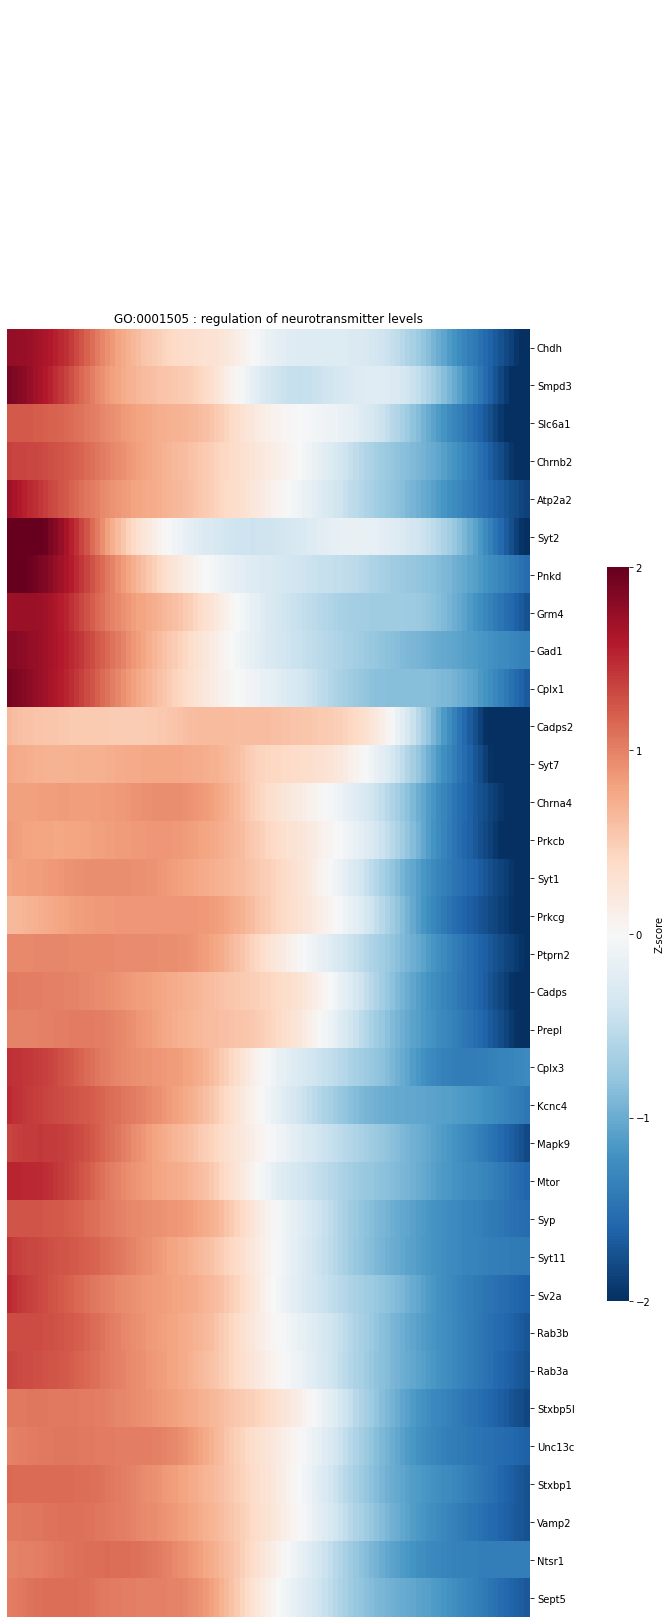

In [39]:
plot.heatmap_with_plist(upplist, up_texts, up_res, genx_A, ex_glists)
plot.heatmap_with_plist(dnplist, dn_texts, dn_res, genx_A, ex_glists)

In [40]:
uextlist = analysis.get_extlist(upplist)
dextlist = analysis.get_extlist(dnplist)
print (uextlist)
print (dextlist)

[['WP103']
 ['mmu04666']
 ['GO:0007229']]
[['WP434']
 ['mmu04721']
 ['GO:0001505']]


/Users/jinhee/Documents/kbri/rnaseq_gan/final/analysis.py:365: RuntimeWarning: invalid value encountered in log10
  mat_fdr, mat_er = -np.log10(mat_fdr), np.log2(mat_er)
/Users/jinhee/Documents/kbri/rnaseq_gan/final/analysis.py:365: RuntimeWarning: invalid value encountered in log2
  mat_fdr, mat_er = -np.log10(mat_fdr), np.log2(mat_er)
/Users/jinhee/Documents/kbri/lib/python3.7/site-packages/seaborn/matrix.py:1165: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


<Figure size 432x288 with 0 Axes>

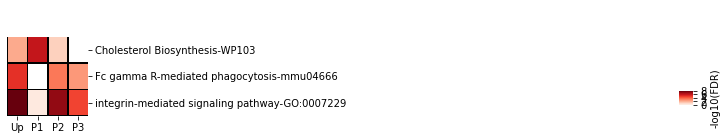

<Figure size 432x288 with 0 Axes>

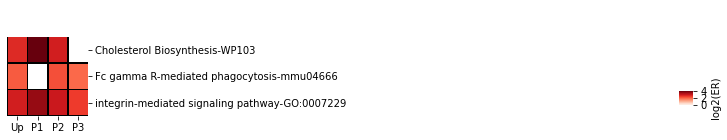

<Figure size 432x288 with 0 Axes>

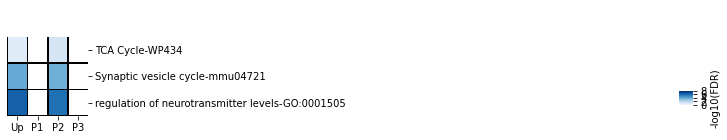

<Figure size 432x288 with 0 Axes>

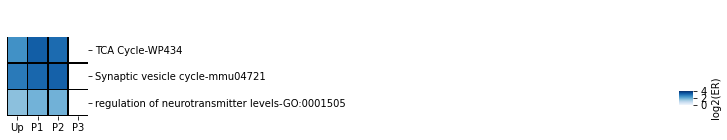

In [41]:
utitle, umat_fdr, umat_er= analysis.get_plotinfo(0, upplist, uextlist)#0:up, 1:dn
dtitle, dmat_fdr, dmat_er= analysis.get_plotinfo(1, dnplist, dextlist)#0:up, 1:dn

plot.FDR_ER(0, utitle, umat_fdr, umat_er)
plot.FDR_ER(1, dtitle, dmat_fdr, dmat_er)

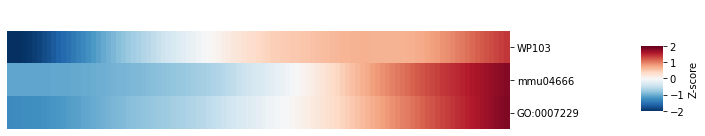

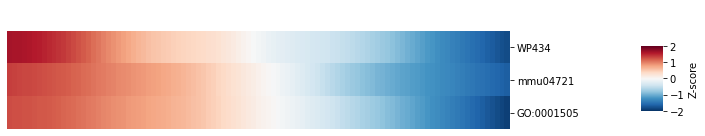

In [42]:
plot.heatmap_with_plist(upplist, up_texts, up_res, genx_A, ex_glists, 1)
plot.heatmap_with_plist(dnplist, dn_texts, dn_res, genx_A, ex_glists, 1)

In [45]:
#save genx_A to csv
snlist = ['2M', '4M', '7M']
for ag in range(len(genx_A)):
    sname = 'weights/genx_'+snlist[ag]+'.csv'
    smat = np.concatenate((ex_glists.reshape((1,len(ex_glists))), genx_A[ag]), axis=0)
    np.savetxt(sname, smat, fmt='%s', delimiter=',')

In [46]:
dat = np.loadtxt('weights/genx_7M.csv', delimiter=',', dtype='str')
clists = np.array(['new_6tv_ver3_7m'])
path = 'rld1_gse104775_genx_247m_75K_125K/'
trait_vect = np.loadtxt('ver3_6trait_vectors.csv', delimiter='\t', dtype=np.float32)

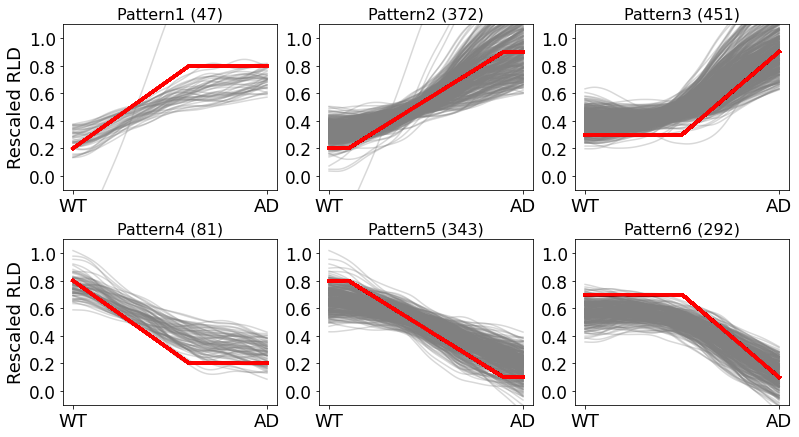

In [47]:
plot.pattern_of_curves(dat, clists, path, trait_vect, 1) #cond:if 7M true else false